In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=scipy.integrate.IntegrationWarning)

Класс для работы с трапециевидными нечёткими множествами $\text{FS}(a,b,c,d)$:

In [ ]:
def trapezoid_mf(a, b, c, d):
  '''
  Вспомогательная функция для получения функции принадлежности трапециевидного НМ.
  '''
  return lambda x: \
    0 if x <= a or x >= d else \
    (x - a) / (b - a) if a < x <= b else \
    1 if b <= x <= c else \
    (d - x) / (d - c) if c < x <= d else \
    None

class FuzzySet:
  def __init__(self, a, b, c, d, u_min=None, u_max=None):
    '''
    a,b,c,d - значения, задающие НМ FS(a,b,c,d)
    [u_min, u_max] - универсум, по умолчанию [a,d]
    '''
    self.mf = trapezoid_mf(a, b, c, d)
    self.min = u_min if u_min != None else a
    self.max = u_max if u_max != None else d
    self.a, self.b, self.c, self.d = a, b, c, d

  def plot(self):
    '''
    Функция для построения графика функции принадлежности НМ.
    '''
    xs = np.linspace(self.min, self.max, 100)
    ys = [self.mf(x) for x in xs]
    plt.plot(xs, ys)
    plt.xlim(self.min, self.max)

  def specificity(self):
    '''
    Функция для расчёта специфичности НМ.
    '''
    return 1 - (self.c + self.d - (self.a + self.b)) / (2 * (self.max - self.min))

Функция для построения гистограммы (как функции!) по набору данных:

In [ ]:
def histogram(data, bins):
  '''
  data - набор данных
  bins - количество интервалов или строка sturges, sqrt и т.п.

  Возвращает функцию-гистограмму.
  '''
  hist, bin_edges = np.histogram(data, bins, density=True)
  def h(x):
    for i in range(len(hist)):
      if bin_edges[i] <= x < bin_edges[i + 1]:
        return hist[i]
    return 0
  return h

Функция для построения B-части Z-числа при фиксированной A-части (согласно подходу, предложенному в разделе 4.1 работы):

In [ ]:
def calculate_b_part(A: FuzzySet, data, bins_min=3, bins_max=None, bins_step=1, bins_best=None, only_peak=False) -> FuzzySet:
  '''
  A - данная A-часть Z-числа
  data - набор данных

  Строятся гистограммы с разбиением на k интервалов, где k перебирается от bins_min до bins_max с шагом bins_step.
  По умолчанию bins_min = 3, bins_max = len(data), bins_step = 1.

  bins_best - наилучшее количество интервалов в гистограмме, допускаются также значения sturges и sqrt.
  Должно быть выполнено bins_min <= bins_best <= bins_max или bins_best in ['sturges', 'sqrt'].
  По умолчанию bins_best = 'sturges'.

  Возвращает B-часть Z-числа, соответствующую данной A-части
  '''
  if bins_max == None:
    bins_max = len(data)
  if bins_best == None or bins_best == 'sturges':
    bins_best = 1 + np.ceil(np.log(len(data)) / np.log(2))
  elif bins_best == 'sqrt':
    bins_best = np.ceil(np.sqrt(len(data)))
  bins_best = int(bins_best)

  assert(bins_min <= bins_best <= bins_max)

  a, b = min(data.min(), A.min), max(data.max(), A.max)

  if only_peak:
    c = scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, bins_best)(x), a=a, b=b)[0]
    return FuzzySet(c, c, c, c, 0, 1)

  l, c, r = None, None, None
  for bins in range(bins_min, bins_max, bins_step):
    similarity = scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, bins)(x), a=a, b=b)[0]
    if l == None or similarity < l:
      l = similarity
    if r == None or similarity > r:
      r = similarity
    if bins == bins_best:
      c = similarity

  if c == None:
    c = scipy.integrate.quad(lambda x: A.mf(x) * histogram(data, bins_best)(x), a=a, b=b)[0]

  return FuzzySet(l, c, c, r, 0, 1)

Класс для построения Z-чисел по набору данных:

In [ ]:
class ZNumber:
  def __init__(self):
    pass

  def fit(self, data,
          bins_min=3, bins_max=None, bins_step=1, bins_best=None,
          u_min=None, u_max=None, u_step=None,
          optimize='specificity', beta=0.5, s_threshold=0.5, c_threshold=0.7,
          defuzzify='peak'):
    '''
    Описания параметров bins_* см. в комментарии к функции calculate_b_part.

    Перебор значений a,b,c,d, задающих A-часть FS(a,b,c,d), производится на отрезке [u_min, u_max] с шагом u_step.
    По умолчанию u_min = min(data), u_max = max(data), u_step = (u_max - u_min) / 10.

    optimize: 'specificity', 'b' или 'both' - что устремляется к максимуму (см. раздел 4.2 работы)
    beta, s_threshold, c_threshold - параметры оптимизации (см. раздел 4.2 работы)

    defuzzify: 'centroid' или 'peak' - дефаззификация B-части методом центроидов или по координате вершины
    '''
    if u_min == None:
      u_min = min(data)
    if u_max == None:
      u_max = max(data)
    if u_step == None:
      u_step = (u_max - u_min) / 10

    best_score = None
    best_subscore = None
    best_A = None

    for a in tqdm(np.linspace(u_min, u_max, int((u_max - u_min) / u_step) + 1)):
      for b in np.linspace(a, u_max, int((u_max - a) / u_step) + 1):
        for c in np.linspace(b, u_max, int((u_max - b) / u_step) + 1):
          for d in np.linspace(c, u_max, int((u_max - c) / u_step) + 1):
            A = FuzzySet(a, b, c, d, u_min, u_max)
            specificity = A.specificity()

            if optimize == 'b' and specificity < s_threshold:
              continue

            B = calculate_b_part(A, data, bins_min, bins_max, bins_step, bins_best, only_peak=(defuzzify == 'peak'))
            b_defuzzified = (B.a + B.b + B.d) / 3 if defuzzify == 'centroid' else B.b

            if optimize == 'specificity' and b_defuzzified < c_threshold:
              continue

            if optimize == 'specificity':
              score = specificity
              subscore = b_defuzzified
            elif optimize == 'b':
              score = b_defuzzified
              subscore = specificity
            elif optimize == 'both':
              score = beta * b_defuzzified + (1 - beta) * specificity
              subscore = score

            if best_score == None or best_score < score or best_score == score and best_subscore < subscore:
              best_score = score
              best_subscore = subscore
              best_A = A

    self.A = best_A
    self.B = calculate_b_part(best_A, data, bins_min, bins_max, bins_step, bins_best, only_peak=False)

  def plot(self):
    print(f"A = FS({self.A.a}, {self.A.b}, {self.A.c}, {self.A.d})")
    print(f"B = FS({self.B.a}, {self.B.b}, {self.B.d})")
    plt.figure(figsize=(10,5))

    plt.subplot(1, 2, 1)
    self.A.plot()
    plt.title('A-часть')

    h = np.histogram(data, density=True)
    plt.stairs(h[0] / max(h[0]), h[1], fill=True, color=(1, 0.5, 0, 0.4))

    plt.subplot(1, 2, 2)
    self.B.plot()
    plt.ylim(0, 1.05)
    plt.title('B-часть')

    plt.show()

Сгенерируем выборку размера 1000 из смеси гауссовских распределений $\mathcal N(0,1)$ и $\mathcal N(2,1)$. Для наглядности построим гистограмму.

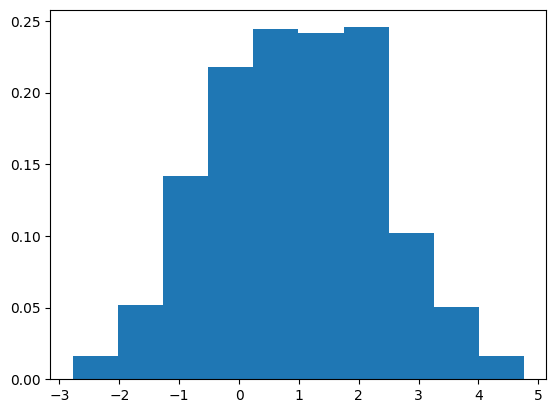

In [ ]:
np.random.seed(0)
data = np.hstack([
    np.random.normal(0, 1, 500),
    np.random.normal(2, 1, 500)
])
plt.hist(data, density=True)
plt.show()

Выведем набор данных:

In [ ]:
data

array([ 1.76405235e+00,  4.00157208e-01,  9.78737984e-01,  2.24089320e+00,
        1.86755799e+00, -9.77277880e-01,  9.50088418e-01, -1.51357208e-01,
       -1.03218852e-01,  4.10598502e-01,  1.44043571e-01,  1.45427351e+00,
        7.61037725e-01,  1.21675016e-01,  4.43863233e-01,  3.33674327e-01,
        1.49407907e+00, -2.05158264e-01,  3.13067702e-01, -8.54095739e-01,
       -2.55298982e+00,  6.53618595e-01,  8.64436199e-01, -7.42165020e-01,
        2.26975462e+00, -1.45436567e+00,  4.57585173e-02, -1.87183850e-01,
        1.53277921e+00,  1.46935877e+00,  1.54947426e-01,  3.78162520e-01,
       -8.87785748e-01, -1.98079647e+00, -3.47912149e-01,  1.56348969e-01,
        1.23029068e+00,  1.20237985e+00, -3.87326817e-01, -3.02302751e-01,
       -1.04855297e+00, -1.42001794e+00, -1.70627019e+00,  1.95077540e+00,
       -5.09652182e-01, -4.38074302e-01, -1.25279536e+00,  7.77490356e-01,
       -1.61389785e+00, -2.12740280e-01, -8.95466561e-01,  3.86902498e-01,
       -5.10805138e-01, -

100%|██████████| 6/6 [00:37<00:00,  6.17s/it]


A = FS(-2.0, 0.0, 2.0, 4.0)
B = FS(0.7097033618235745, 0.8004213047325306, 0.8167687499092329)


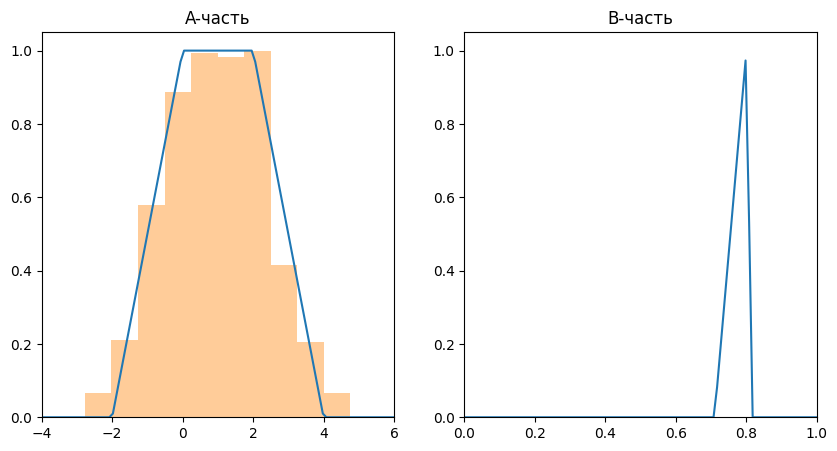

In [ ]:
z = ZNumber()
z.fit(data, bins_max=100, bins_step=5, defuzzify='peak', u_min=-4, u_max=6, u_step=2)
z.plot()

100%|██████████| 6/6 [00:28<00:00,  4.71s/it]


A = FS(-2.0, -2.0, 2.0, 4.0)
B = FS(0.7986964908146827, 0.8936464734250231, 0.90689309343801)


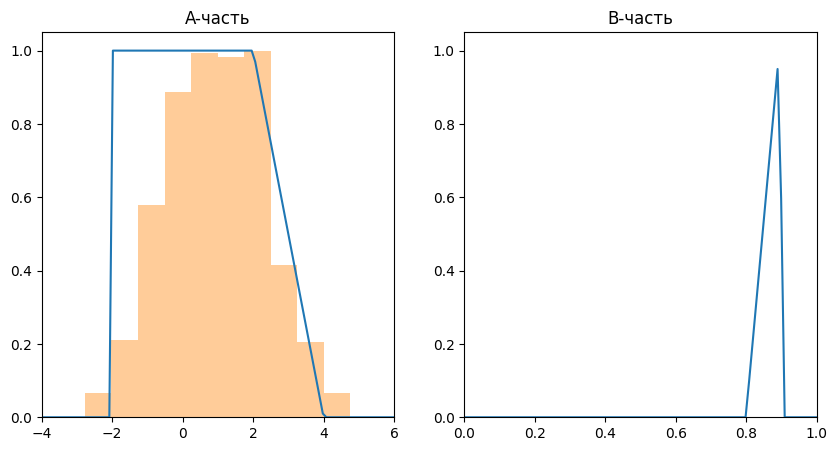

In [ ]:
z = ZNumber()
z.fit(data, bins_max = 100, bins_step = 5, defuzzify='peak', u_min=-4, u_max=6, u_step=2, optimize='b', s_threshold=0.5)
z.plot()

100%|██████████| 6/6 [00:37<00:00,  6.18s/it]


A = FS(-2.0, 0.0, 2.0, 4.0)
B = FS(0.7097033618235745, 0.8004213047325306, 0.8167687499092329)


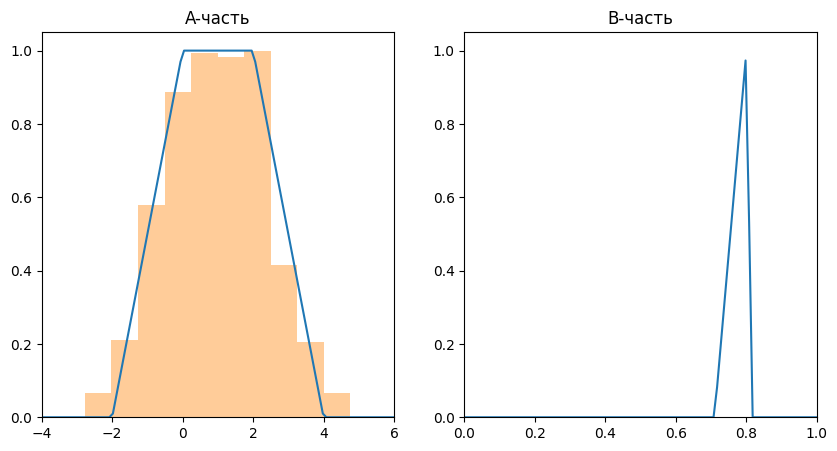

In [ ]:
z = ZNumber()
z.fit(data, bins_max = 100, bins_step = 5, defuzzify='peak', u_min=-4, u_max=6, u_step=2, optimize='both', beta=0.5)
z.plot()